In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

While the rate of fatal road accidents has been decreasing steadily since the 80s, the past ten years have seen a stagnation in this reduction. Coupled with the increase in number of miles driven in the nation, the total number of traffic related-fatalities has now reached a ten year high and is rapidly increasing.

Per request of the US Department of Transportation, we are currently investigating how to derive a strategy to reduce the incidence of road accidents across the nation. By looking at the demographics of traﬃc accident victims for each US state, we find that there is a lot of variation between states. Now we want to understand if there are patterns in this variation in order to derive suggestions for a policy action plan. In particular, instead of implementing a costly nation-wide plan we want to focus on groups of states with similar profiles. How can we find such groups in a statistically sound way and communicate the result effectively?

To accomplish these tasks, we will make use of data wrangling, plotting, dimensionality reduction, and unsupervised clustering.

### 1. Read in and get an overview of the data

In [74]:
# Read the DataFrame
car_acc=pd.read_csv("bad-drivers.csv")
print(car_acc.columns)

## Change column name
abr_colName=["state","drvr_fatl_col_bmiles","perc_fatl_speed","perc_fatl_alcohol",'perc_fatl_not_distc','perc_fatl_1st_time','car_insur_prem','losses']
car_acc=car_acc.set_axis(abr_colName, axis=1, inplace=False)

# Display the last five rows of the DataFrame
car_acc.tail()

Index(['State',
       'Number of drivers involved in fatal collisions per billion miles',
       'Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding',
       'Percentage Of Drivers Involved In Fatal Collisions Who Were Alcohol-Impaired',
       'Percentage Of Drivers Involved In Fatal Collisions Who Were Not Distracted',
       'Percentage Of Drivers Involved In Fatal Collisions Who Had Not Been Involved In Any Previous Accidents',
       'Car Insurance Premiums ($)',
       'Losses incurred by insurance companies for collisions per insured driver ($)'],
      dtype='object')


,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_not_distc,perc_fatl_1st_time,car_insur_prem,losses
46,Virginia,12.7,19,27,87,88,768.95,153.72
47,Washington,10.6,42,33,82,86,890.03,111.62
48,West Virginia,23.8,34,28,97,87,992.61,152.56
49,Wisconsin,13.8,36,33,39,84,670.31,106.62
50,Wyoming,17.4,42,32,81,90,791.14,122.04


### 2. Create a textual and a graphical summary of the data

In [75]:
# import seaborn and make plots appear inline
import seaborn as sns
%matplotlib inline

# Compute the summary statistics of all columns in the `car_acc` DataFrame
sum_stat_car =car_acc.describe()
sum_stat_car 

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_not_distc,perc_fatl_1st_time,car_insur_prem,losses
count,51.000000,51.000000,51.000000,51.000000,51.00000,51.000000,51.000000
mean,15.790196,31.725490,30.686275,85.921569,88.72549,886.957647,134.493137
std,4.122002,9.633438,5.132213,15.158949,6.96011,178.296285,24.835922
min,5.900000,13.000000,16.000000,10.000000,76.00000,641.960000,82.750000
25%,12.750000,23.000000,28.000000,83.000000,83.50000,768.430000,114.645000
50%,15.600000,34.000000,30.000000,88.000000,88.00000,858.970000,136.050000
75%,18.500000,38.000000,33.000000,95.000000,95.00000,1007.945000,151.870000
max,23.900000,54.000000,44.000000,100.000000,100.00000,1301.520000,194.780000


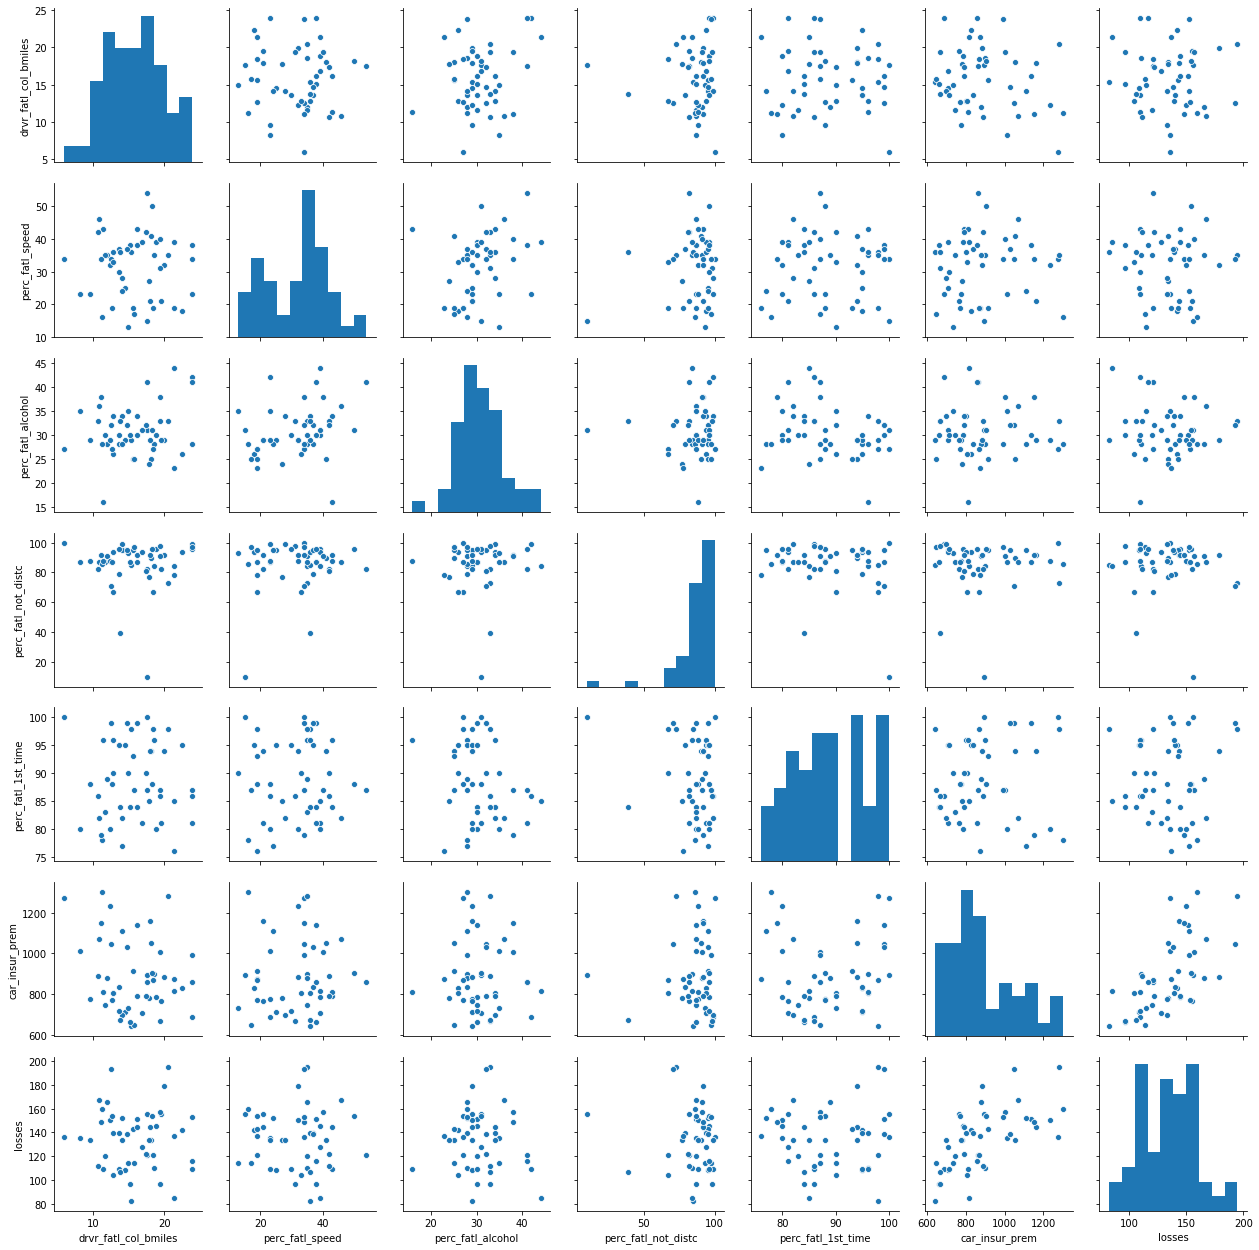

In [76]:
# Create a pairwise scatter plot to explore the data
sns.pairplot(car_acc);

### 3. Quantify the association of features and accidents
We can already see some potentially interesting relationships between the target variable (the number of fatal accidents) and the feature variables (the remaining three columns).

To quantify the pairwise relationships that we observed in the scatter plots, we can compute the Pearson correlation coefficient matrix. The Pearson correlation coefficient is one of the most common methods to quantify correlation between variables, and by convention, the following thresholds are usually used:

- 0.2 = weak
- 0.5 = medium
- 0.8 = strong
- 0.9 = very strong


In [77]:
# Create a correlation matrix
corr_metrics = car_acc.corr()
corr_metrics.style.background_gradient()

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_not_distc,perc_fatl_1st_time,car_insur_prem,losses
drvr_fatl_col_bmiles,1,-0.0290801,0.199426,0.00978176,-0.0179419,-0.199702,-0.0360111
perc_fatl_speed,-0.0290801,1,0.286244,0.131738,0.0140662,0.0425413,-0.0612405
perc_fatl_alcohol,0.199426,0.286244,1,0.0433798,-0.245455,-0.0174507,-0.0839159
perc_fatl_not_distc,0.00978176,0.131738,0.0433798,1,-0.195265,0.0195781,-0.0584668
perc_fatl_1st_time,-0.0179419,0.0140662,-0.245455,-0.195265,1,0.0755331,0.0427701
car_insur_prem,-0.199702,0.0425413,-0.0174507,0.0195781,0.0755331,1,0.623116
losses,-0.0360111,-0.0612405,-0.0839159,-0.0584668,0.0427701,0.623116,1


From the above plot, there is not a much strong correlation between any of the features but a medium between `Losses` and `Car Insurance Premiums`. So, we need to remove `Losses` from our data.

### 4. Fit a multivariate linear regression
From the correlation table, we see that the amount of fatal accidents is most strongly correlated with alcohol consumption (first row). But in addition, we also see that some of the features are correlated with each other, for instance, speeding and alcohol consumption are positively correlated. We, therefore, want to compute the association of the target with each feature while adjusting for the effect of the remaining features. This can be done using multivariate linear regression.

Both the multivariate regression and the correlation measure how strongly the features are associated with the outcome (fatal accidents). When comparing the regression coefficients with the correlation coefficients, we will see that they are slightly different. The reason for this is that the multiple regression computes the association of a feature with an outcome, given the association with all other features, which is not accounted for when calculating the correlation coefficients.

A particularly interesting case is when the correlation coefficient and the regression coefficient of the same feature have opposite signs. How can this be? For example, when a feature A is positively correlated with the outcome Y but also positively correlated with a different feature B that has a negative effect on Y, then the indirect correlation (A->B->Y) can overwhelm the direct correlation (A->Y). In such a case, the regression coefficient of feature A could be positive, while the correlation coefficient is negative. This is sometimes called a masking relationship. Let’s see if the multivariate regression can reveal such a phenomenon.

In [78]:
# Import the linear model function from sklearn
from sklearn import linear_model

# Create the features and target DataFrames
features = car_acc.loc[:,["perc_fatl_speed","perc_fatl_alcohol",'perc_fatl_not_distc','perc_fatl_1st_time','car_insur_prem']]
target = car_acc.loc[:,"drvr_fatl_col_bmiles"]

# Create a linear regression object
reg = linear_model.LinearRegression()

# Fit a multivariate linear regression model
reg.fit(features, target)

# Retrieve the regression coefficients
fit_coef = reg.coef_
fit_coef

array([-0.03976136,  0.18997494,  0.00752192,  0.03653581, -0.00455031])

### 5. Perform PCA on standardized data
We have learned that alcohol consumption is weakly associated with the number of fatal accidents across states. This could lead us to conclude that alcohol consumption should be a focus for further investigations and maybe strategies should divide states into high versus low alcohol consumption in accidents. But there are also associations between alcohol consumptions and the other two features, so it might be worth trying to split the states in a way that accounts for all three features.

One way of clustering the data is to use PCA to visualize data in reduced dimensional space where we can try to pick up patterns by eye. PCA uses the absolute variance to calculate the overall variance explained for each principal component, so it is important that the features are on a similar scale (unless we would have a particular reason that one feature should be weighted more).

We'll use the appropriate scaling function to standardize the features to be centered with mean 0 and scaled with standard deviation 1.

In [87]:
from sklearn.preprocessing import StandardScaler
scaler =StandardScaler()
dat=car_acc.drop(["state"],axis=1).set_index("drvr_fatl_col_bmiles")
colName= ["feature%s"%(i+1) for i in range(0,dat.shape[1])]
ind=dat.index
dat_scaled = scaler.fit_transform(dat)
df_scaled = pd.DataFrame(dat_scaled).set_axis(colName, axis=1,inplace=False) ## set column name
df_scaled.set_index(ind,inplace=True)
df_scaled.head()

,feature1,feature2,feature3,feature4,feature5,feature6
drvr_fatl_col_bmiles,,,,,,
18.8,0.762645,-0.135050,0.671466,-1.266117,-0.580083,0.430514
18.1,0.972321,-1.118982,0.271722,0.765361,0.943258,-0.022900
18.6,0.343293,-0.528623,-0.128023,1.055572,0.070876,-0.981778
22.4,-1.438953,-0.922196,0.538218,0.910466,-0.337701,0.321125
12.0,0.343293,-0.528623,0.338346,0.039833,-0.048418,1.266178


In [88]:
from sklearn import decomposition
pca=decomposition.PCA()
pca.fit(df_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

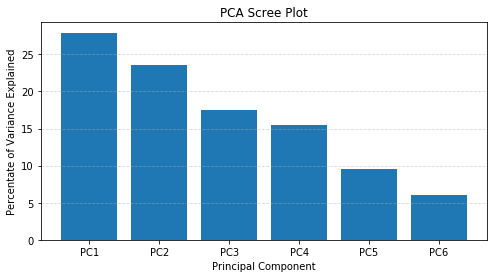

Cumulative explained variance:


array([0.28, 0.52, 0.69, 0.85, 0.95, 1.01])

In [89]:
# plot the explained variance using a barplot
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = ["PC%d"%(i+1) for i in range(0,df.shape[1])] 
plt.figure(figsize=(8, 4))
plt.bar(x= range(0,df.shape[1]), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.grid(alpha=.5,linestyle='--',axis="y")
plt.show()

# Calculate the cumulative explained variance
print("Cumulative explained variance:")
np.cumsum(np.round(pca.explained_variance_ratio_, decimals =2))

### 6. Visualize the first two and the first three principal components
The first two and three principal components enable visualization of the data in two and three dimensions while capturing the variation of 52% and 69% from all six features. This enables us to use our eyes to try to discern patterns in the data with the goal to find groups of similar states. Although clustering algorithms are becoming increasingly efficient, human pattern recognition is an easily accessible and very efficient method of assessing patterns in data.

We will create a scatter plot of the first principle components and explore how the states cluster together in this visualization.

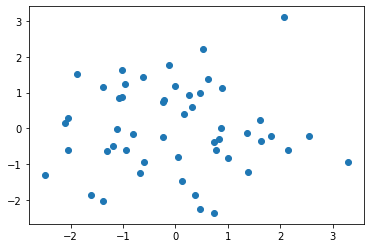

In [114]:
## Perform PCA with two components and project data onto components
pca_2d=decomposition.PCA(n_components=2)
pca_2d.fit(df_scaled)
df_reduced=pca_2d.transform(df_scaled)
df_reduced=pd.DataFrame(df_reduced).set_index(ind)
new_df_2d=df_reduced.reset_index()
plt.scatter(new_df_2d[0],new_df_2d[1]);

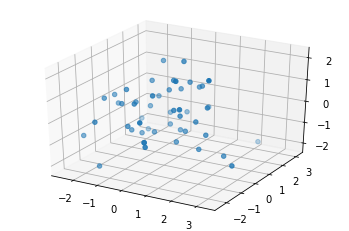

In [115]:
## Perform PCA with three components and project data onto components
pca_3d=decomposition.PCA(n_components=3)
pca_3d.fit(df_scaled)
df_reduced=pca_new.transform(df_scaled)
df_reduced=pd.DataFrame(df_reduced).set_index(ind)
new_df_3d=df_reduced.reset_index()

ax = plt.axes(projection='3d')
ax.scatter3D(new_df_3d[0],new_df_3d[1],new_df_3d[2]);

### 7. Find clusters of similar states in the data
It was not entirely clear from the PCA scatter plot how many groups in which the states cluster. To assist with identifying a reasonable number of clusters, we can use KMeans clustering by creating a scree plot and finding the "elbow", which is an indication of when the addition of more clusters does not add much explanatory power.

In [90]:
df_scaled.head()

,feature1,feature2,feature3,feature4,feature5,feature6
drvr_fatl_col_bmiles,,,,,,
18.8,0.762645,-0.135050,0.671466,-1.266117,-0.580083,0.430514
18.1,0.972321,-1.118982,0.271722,0.765361,0.943258,-0.022900
18.6,0.343293,-0.528623,-0.128023,1.055572,0.070876,-0.981778
22.4,-1.438953,-0.922196,0.538218,0.910466,-0.337701,0.321125
12.0,0.343293,-0.528623,0.338346,0.039833,-0.048418,1.266178


In [ ]:
####### Method 1 ########

1. Selecting the number of clusters with inertia which is the mean squared distance between each instance and its closest centroid

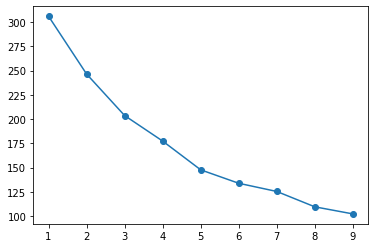

In [98]:
from sklearn.cluster import KMeans

# A loop will be used to plot the explanatory power for up to 10 KMeans clusters
ks = range(1, 10)
inertias = []
for k in ks:
    # Initialize the KMeans object using the current number of clusters (k)
    km = KMeans(n_clusters=k, random_state=8)
    # Fit the scaled features to the KMeans object
    km.fit(df_scaled)
    # Append the inertia for `km` to the list of inertias
    inertias.append(km.inertia_)
    
# Plot the results in a line plot
plt.plot(ks, inertias, marker='o');

There isn't a clear elbow in the scree plot.

In [103]:
####### Method 2 ########

2. Selecting the number of clusters with silhouette analysis on KMeans clustering

Counter({0: 26, 1: 25})
0.16851520887137458 clusters:2
------
Counter({1: 18, 0: 18, 2: 15})
0.1823779849866921 clusters:3
------
Counter({1: 21, 2: 16, 0: 13, 3: 1})
0.1783830480353571 clusters:4
------
Counter({2: 15, 0: 14, 1: 13, 4: 7, 3: 2})
0.20533845892332253 clusters:5
------
Counter({1: 15, 3: 10, 0: 9, 5: 9, 2: 7, 4: 1})
0.18915085222297803 clusters:6
------
Counter({2: 13, 1: 13, 3: 9, 4: 8, 6: 5, 0: 2, 5: 1})
0.18866992264807028 clusters:7
------
Counter({4: 9, 1: 8, 3: 8, 2: 8, 0: 8, 7: 5, 6: 4, 5: 1})
0.18395987638515687 clusters:8
------
Counter({2: 11, 5: 9, 7: 8, 8: 5, 1: 5, 3: 5, 0: 4, 6: 3, 4: 1})
0.17293516855375066 clusters:9
------


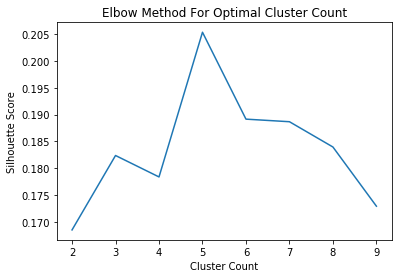

In [99]:

from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import silhouette_samples, silhouette_score

Sum_of_squared_distances = []
scores = []
cluster_count = []
K= range(2,10,1)
for i in K:
    km = KMeans(n_clusters=i,random_state=8)
    km.fit(df_scaled)
    pred =km.predict(df_scaled)
    Sum_of_squared_distances.append(km.inertia_)
    scores.append(silhouette_score(df_scaled, pred))
    cluster_count.append(i)
    print(Counter(pred))
    print(str(silhouette_score(df_scaled, pred)) + ' clusters:' +str(i))
    print('------')
########################################
### Elbow plot with silhouette score ###
########################################
plt.plot(cluster_count,scores)
plt.xlabel('Cluster Count')
plt.ylabel('Silhouette Score')
plt.title('Elbow Method For Optimal Cluster Count')
plt.show()

`k=5` should be chosen for the number of clusters. This method is better as it makes the decision regarding the optimal number of clusters more meaningful and clear.  

### 8. KMeans to visualize clusters in the PCA scatter plot

In [128]:
# Create a KMeans object with 3 clusters, use random_state=8 
km = KMeans(n_clusters=5, random_state=8)

# Fit the data to the `km` object
p_comps = km.fit_transform(df_scaled)

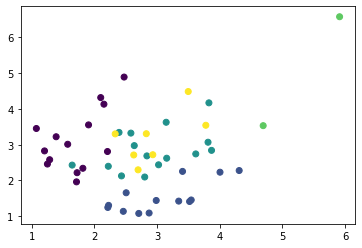

In [129]:
# Create a scatter plot of the first two principal components
# and color it according to the KMeans cluster assignment 
plt.scatter(p_comps[:,0],p_comps[:,1],c=km.labels_);

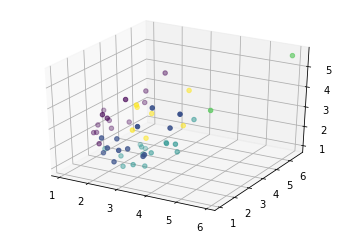

In [130]:
# Create a scatter plot of the first three principal components
# and color it according to the KMeans cluster assignment 
ax = plt.axes(projection='3d')
ax.scatter3D(p_comps[:,0],p_comps[:,1],p_comps[:,2],c=km.labels_);

### 10. Visualize the feature differences between the clusters
Thus far, we have used both our visual interpretation of the data and the KMeans clustering algorithm to reveal patterns in the data, but what do these patterns mean?

Remember that the information we have used to cluster the states into five distinct groups are the percentage of drivers speeding, under alcohol influence, were not distracted,that has not previously been involved in an accident and car insurance premiums. We used these clusters to visualize how the states group together when considering the first two and three principal components. This is good for us to understand structure in the data, but not always easy to understand, especially not if the findings are to be communicated to a non-specialist audience.

A reasonable next step in our analysis is to explore how the three clusters are different in terms of the five features that we used for clustering. Instead of using the scaled features, we return to using the unscaled features to help us interpret the differences.



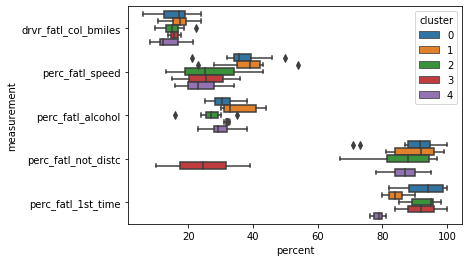

In [159]:
# Create a new column with the labels from the KMeans clustering
car_acc['cluster'] = km.labels_

new_df=car_acc.drop(["state","car_insur_prem","losses"],axis=1)
features=[]
# Reshape the DataFrame to the long format
melt_car = pd.melt(new_df, id_vars="cluster", var_name="measurement", value_name="percent")

# Create a box plot splitting and coloring the results according to the km-clusters
sns.boxplot(x=melt_car["percent"], y=melt_car["measurement"], hue=melt_car["cluster"]);

### 10. Compute the number of accidents within each cluster
Now it is clear that different groups of states may require different interventions. Since resources and time are limited, it is useful to start off with an intervention in one of the three groups first. Which group would this be? To determine this, we will include data on how many miles are driven in each state, because this will help us to compute the total number of fatal accidents in each state. Data on miles driven is available in another tab-delimited text file. We will assign this new information to a column in the DataFrame and create a violin plot for how many total fatal traffic accidents there are within each state cluster.

,count,mean,sum
cluster,,,
0,14,1357.995179,19011.9325
1,13,673.907169,8760.7932
2,15,646.653500,9699.8025
3,2,745.911400,1491.8228
4,7,952.979914,6670.8594


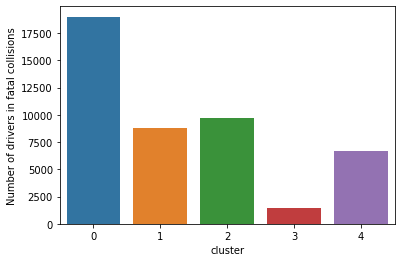

In [174]:
# Read in the new dataset
miles_driven = pd.read_csv('miles-driven.csv', sep='|')

# Merge the `car_acc` DataFrame with the `miles_driven` DataFrame
car_acc_miles = pd.merge(car_acc, miles_driven, on="state")

# Create a new column for the number of drivers involved in fatal accidents
car_acc_miles['num_drvr_fatl_col'] = car_acc_miles['drvr_fatl_col_bmiles']*car_acc_miles["million_miles_annually"]/1000

# Create a barplot of the total number of accidents per cluster
sns.barplot(x=car_acc_miles["cluster"], y=car_acc_miles["num_drvr_fatl_col"], data=car_acc_miles, estimator=sum, ci=None)
plt.ylabel("Number of drivers in fatal collisions")

# Calculate the number of states in each cluster and their 'num_drvr_fatl_col' mean and sum.
count_mean_sum = car_acc_miles.groupby("cluster")["num_drvr_fatl_col"].agg(["count", "mean", "sum"])
count_mean_sum

Source: https://projects.datacamp.com/projects/462